# <center> Kaggle House Price Prediction
**by Hyrisky He**

Some notes here: In order to improve my practical python coding ablity and to better master, I will divide the codes into few parts and interpret the process that I made in each steps.

**Downloader:**
Refer to Mu Li's code

In [7]:
import hashlib
import os
import tarfile
import zipfile
import urllib
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

# Dictionary DATA_HUB, binary containing the url of the dataset and the sha-1 key to verify the integrity of the file
def download(name, cache_dir = os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok = True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    
    # show the progress of the download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream = True, verify = True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

### 1. Pull a dataset

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# import a relatively small dataset to train and test the model
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')


DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

# have a glimpse of the data
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


### 2. Processing the data

observe the csv file (column 1 ~ 3 & -3 ~ -1)

In [11]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


notice that the first column is ID which contain any information, so we will delete it.\
the last column is SalePrice which will be used as a label, so we also will take it out.

In [12]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # delete the first column (id) and the last column (price) and combine the train and test data

replace the missing value with the average value, standardize data by rescaling features to zero mean and unit variance.\
_attention: we cannot fill the value first because it will bring bias to the set._

In [13]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # select the numeric features (exclude the object type which means string in python)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # normalize the data
all_features[numeric_features] = all_features[numeric_features].fillna(0) # fill the missing values with 0

furthermore, some data were given as "features", so we use `one-hot encoding` to deal with discrete values.\
_about one-hot encoding, here is a note ([portal here](https://zhuanlan.zhihu.com/p/134495345))_

In [14]:
all_features = pd.get_dummies(all_features, dummy_na = True) # convert the categorical features into dummy variables
all_features.shape

(2919, 331)

**but** as we can see here, using this strategy will extend the features' scale, so we can use `one-hot encoding + PCA` to maintain the scale.

Now, extract NumPy format from pandas, and transform them into tensors.

In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32) # extract the price column as the label

### 3. Train:

In [17]:
loss = nn.MSELoss() #mean squared error
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)) # linear regression single layer
    return net

using logarithmic transformation to express relative error, observe the `rmse` $\frac{y-\hat{y}}{y}$

In [18]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # clamp the predicted value to be greater than 1
    rmse = torch.sqrt(loss(clipped_preds.log(), labels.log())) # calculate the root mean squared error
    return rmse.item()

In [19]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # load the data in batches
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay) # use Adam optimizer
    
    for epoch in range(num_epochs):
        for x, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(x), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels)) # calculate the rmse for the training data
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) # calculate the rmse for the test data
    return train_ls, test_ls

**K fold validify**\
again, XD([portal here](https://blog.csdn.net/Rocky6688/article/details/107296546))

In [20]:
def get_k_fold_data(k, i, x, y):
    assert k > 1
    fold_size = x.shape[0] // k # calculate the size of each fold
    x_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # slice the data into k folds
        x_part, y_part = x[idx, :], y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat((x_train, x_part), 0)
            y_train = torch.cat((y_train, y_part), 0)
    return x_train, y_train, x_valid, y_valid # return the training data and validation data for each fold

return the average value of train and validation error

In [22]:
def k_fold(k, x_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, x_train, y_train) # get the training data and validation data for each fold
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # train the model and get the rmse for each fold
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel = 'epoch', ylabel = 'rmse', xlim = [1, num_epochs], legend = ['train', 'valid'], yscale = 'log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, valid log rmse {float(valid_ls[-1]):f}') # -1 means the last element in the list
    return train_l_sum / k, valid_l_sum / k # return the average rmse for training data and validation data

### 4. Witness the thrilling and suspenseful process of model selection and hyperparameter tuning !

fold 1, train log rmse 0.135591, valid log rmse 0.142533
fold 2, train log rmse 0.133895, valid log rmse 0.149042
fold 3, train log rmse 0.132091, valid log rmse 0.142347
fold 4, train log rmse 0.137725, valid log rmse 0.139953
fold 5, train log rmse 0.130276, valid log rmse 0.168853
5-fold validation: avg train log rmse: 0.133916, avg valid log rmse: 0.148545


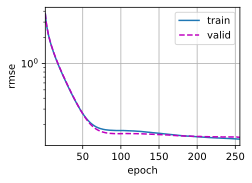

In [25]:
k, num_epochs, lr, weight_decay, batch_size = 5, 256, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

the performance of this num_epochs is quite satisfactory, but I think it is a bit big.

### 5. Further submission

In [26]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel = 'epoch', ylabel = 'log rmse', xlim = [1, num_epochs], yscale = 'log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    answer = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
    answer.to_csv('submission.csv', index = False)

# train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)